In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
import math
import pywt

In [76]:
def contar_imagenes(carpeta, extensiones={'.jpg', '.jpeg', '.png'}):
    return sum(1 for archivo in os.listdir(carpeta) if os.path.splitext(archivo)[1].lower() in extensiones)

In [77]:
rutaDR = "../Data/Image_/DR"
rutaNODR= "../Data/Image_/No_DR"

In [78]:
n1 = contar_imagenes(rutaDR)
n2 = contar_imagenes(rutaNODR)

carpetas = ['NO_ DR', 'DR']
valores = [n1, n2]

In [79]:
print(n1,n2)

1408 1430


In [80]:
tam_image = 256

rutaDR = "../Data/Image_/DR/"
rutaNODR= "../Data/Image_/No_DR/"

imagenes_retina_NODR = []
imagenes_retina_DR = []

In [81]:
for index, path in enumerate(tqdm((range(n1)), desc="Cargando Imagenes: ")):
    #print(index)
    img_aux = cv2.imread(rutaDR+str(index+1)+".jpg")
    img_aux = cv2.cvtColor(img_aux, cv2.COLOR_BGR2RGB)
    img_aux = cv2.resize(img_aux,(tam_image,tam_image),interpolation=cv2.INTER_LANCZOS4)

    imagenes_retina_DR.append(img_aux)

Cargando Imagenes: 100%|██████████| 1408/1408 [00:02<00:00, 515.69it/s]


In [82]:
for index, path in enumerate(tqdm((range(n2)), desc="Cargando Imagenes: ")):
    img_aux = cv2.imread(rutaNODR+str(index+1)+".jpg")
    img_aux = cv2.cvtColor(img_aux, cv2.COLOR_BGR2RGB)
    img_aux = cv2.resize(img_aux,(tam_image,tam_image),interpolation=cv2.INTER_LANCZOS4)

    imagenes_retina_NODR.append(img_aux)

Cargando Imagenes: 100%|██████████| 1430/1430 [00:02<00:00, 508.51it/s]


In [83]:
def ajuste_brillo_contraste(image):
    mean, stddev = cv2.meanStdDev(image)
    mediana = np.percentile(image.flatten(), 50)
    ax = 128 - mediana
    alpha = np.clip(100 / (stddev[0][0] + 1e-6), 1.0, 2.0)
    beta = np.clip(ax - mean[0][0], -30, 30)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

In [84]:
def clip_limit_adaptativo(image, base_clip=2.0, scale_factor=5.0, min_limit=0.5, max_limit=2.0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std_dev = np.std(gray_image)
    
    normalized_std = std_dev / 255  
    clip_limit = base_clip + (normalized_std * scale_factor)

    return np.clip(clip_limit, min_limit, max_limit)

In [85]:
def clahe_funcion(image):
    clip_limit_value = min(clip_limit_adaptativo(image), 2.0)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit_value, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l_clahe, a, b)), cv2.COLOR_LAB2BGR)

In [86]:
def recorte_Bordes(img_sinReco):
    gray_image = cv2.cvtColor(img_sinReco, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
    contorno, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contorno:
        return cv2.resize(img_sinReco, (tam_image, tam_image))

    cont = max(contorno, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(cont)
    Imag_recort = img_sinReco[y:y+h, x:x+w]
    Imag_recort = cv2.resize(Imag_recort,(tam_image,tam_image))
    
    return Imag_recort

In [87]:
def auto_gammaCorrection(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    mean = np.mean(v)
    gamma = np.clip(math.log(0.5 * 255) / math.log(mean), 0.8, 1.2)
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

In [88]:
def filtrado_bilateral(image):
    return cv2.bilateralFilter(image,9,5,5)

In [ ]:
for index in tqdm(range(len(imagenes_retina_DR))):
    image_aux = imagenes_retina_DR[index]

    #---------
    
    image_aux = filtrado_bilateral(image_aux)
    image_aux = recorte_Bordes(image_aux)
    image_aux = ajuste_brillo_contraste(image_aux)
    image_aux = clahe_funcion(image_aux)
    image_aux = auto_gammaCorrection(image_aux)
    
    #----------
    # GUARDADO DE IMAGENES
    imagenes_retina_DR[index] = image_aux

100%|██████████| 1408/1408 [00:17<00:00, 82.06it/s]


In [92]:
for index in tqdm(range(len(imagenes_retina_NODR))):
    image_aux = imagenes_retina_NODR[index]

    #---------
    
    image_aux = filtrado_bilateral(image_aux)
    image_aux = recorte_Bordes(image_aux)
    image_aux = ajuste_brillo_contraste(image_aux)
    image_aux = clahe_funcion(image_aux)
    image_aux = auto_gammaCorrection(image_aux)
    
    #----------
    # GUARDADO DE IMAGENES
    imagenes_retina_NODR[index] = image_aux

100%|██████████| 1430/1430 [00:17<00:00, 82.83it/s]


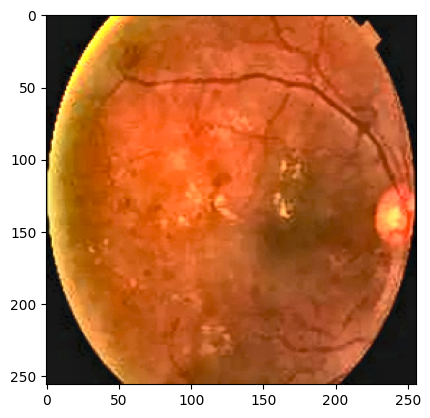

In [90]:
plt.imshow(imagenes_retina_DR[0])

In [94]:
etiquetas = ["00_NO DR", "01_DR"]
mk_direccion = "../Data/Image_Preprocessing_Binary_Image/"

In [91]:
try:
    os.mkdir("../Data/Image_Preprocessing_Binary_Image")
    print(f" ✔️ La carpeta {"Img_Preprocessing_Binary"} se creo correctamente")
except Exception as e:
    print(f" ⚠️ Ocurrió un error inesperado: {e}")

 ✔️ La carpeta Img_Preprocessing_Binary se creo correctamente


In [100]:
for index in range(len(etiquetas)):
    try:
        os.mkdir(mk_direccion+etiquetas[index])
        print(f" ✔️ La carpeta {etiquetas[index]} se creo correctamente")
    except FileExistsError:
        print(f" ❌ La carpeta {etiquetas[index]} ya existe")
    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")


 ✔️ La carpeta 00_NO DR se creo correctamente
 ✔️ La carpeta 01_DR se creo correctamente


In [101]:
for index in range(len(imagenes_retina_NODR)):
    try:
        tipo = etiquetas[0]
        ruta = os.path.join(mk_direccion, tipo, f"{index}.png")

        if os.path.exists(ruta):
            print(f" ❌ La Imagen {index} ya existe")
            continue

        img = imagenes_retina_NODR[index]
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_norm.astype(np.uint8)
        cv2.imwrite(ruta, cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))

    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")


In [102]:
for index in range(len(imagenes_retina_DR)):
    try:
        tipo = etiquetas[1]
        ruta = os.path.join(mk_direccion, tipo, f"{index}.png")

        if os.path.exists(ruta):
            print(f" ❌ La Imagen {index} ya existe")
            continue

        img = imagenes_retina_DR[index]
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_norm.astype(np.uint8)
        cv2.imwrite(ruta, cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))

    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")
